# A Comparative Study of the SIRD Model and the ARIMA Model in Predicting COVID-19 Cases


Zhong Ruoyu and Li Xingjian

School of Computer Science and Engineering

Nanyang Technological University

April 2021


__TODO__: background


## Prerequesites


### Dependencies


In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from statsmodels.tsa.arima.model import ARIMA


### Plotting Style Setting


In [2]:
sb.set(rc={"figure.figsize": (12, 8)})


### IPython Utility


In [3]:
from IPython.display import clear_output


## Warning Filtering


In [4]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


## Data Acquisition and Cleanup

Wisconsin can be a state of our interest. Reasons include:
- It has an appropriate population density (ranked 25th among the 50 states, according to [Wikipedia]()).
- Located inland and being not as developed as the states with metropolitans (e.g. New York, California), population movement is not as significant.
- Government control on the pandemic was not as effective. (This is sad, but it enables us to focus on the pandemic itself.)

The location of Wisconsin in the United States:

![Wisconsin in United States](https://upload.wikimedia.org/wikipedia/commons/a/a7/Wisconsin_in_United_States.svg)

[Picture](https://commons.wikimedia.org/wiki/File:Wisconsin_in_United_States.svg) from [TUBS](https://commons.wikimedia.org/wiki/User:TUBS), under CC BY-SA 3.0.


In [5]:
state = "Wisconsin"


First things first, we utilise the API provided by [the COVID Tracking Project](https://covidtracking.com/) to obtain the data.

Note that in `get_data`, We make use of [the List of U.S. States with Codes and Abbreviations](https://www23.statcan.gc.ca/imdb/p3VD.pl?Function=getVD&TVD=53971), provided by [Statistics Canada](https://www.statcan.gc.ca/), a Canadian government website, to obtain the state code corresponding to the state (e.g. "CA" for California). (Yes, it's strange to get that information from a Canadian government website, but anyway, it works!) That is not redundant. We just want to automate everything as much as we can.


In [6]:
def get_data(state):

    def get_state_code(state):
        state_codes = pd.read_html("https://www23.statcan.gc.ca/imdb/p3VD.pl?Function=getVD&TVD=53971")[0]
        code = state_codes[state_codes["State"] == state]["Alpha code"].values[0]
        return code
    
    code = get_state_code(state)
    data = pd.read_json(f"https://api.covidtracking.com/v1/states/{code.lower()}/daily.json")
    return data


raw = get_data(state)
raw


In addition, since the SIRD model requires the total population, we need to obtain the population information of the state as well. We utilise the data provided by [the Census Bureau of the United States](https://www.census.gov/).


In [7]:
def get_population(state):
    pop_data = pd.read_csv("https://www2.census.gov/programs-surveys/popest/datasets/2010-2020/national/totals/nst-est2020.csv")
    population = pop_data[pop_data["NAME"] == state]["POPESTIMATE2020"].values[0]
    return population


population = get_population(state)
population


,date,state,positive,probableCases,negative,pending,totalTestResultsSource,totalTestResults,hospitalizedCurrently,hospitalizedCumulative,...,dataQualityGrade,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
0,20210307,WI,621654.0,54961.0,2647864.0,31.0,totalTestEncountersViral,7080595,249.0,26457.0,...,NaN,4,25,ea0056371780c0d00c44fa4f40092e7e0708a929,0,0,0,0,0,
1,20210306,WI,621277.0,54913.0,2644343.0,36.0,totalTestEncountersViral,7061402,260.0,26432.0,...,NaN,8,45,75f9bf52b10e890bcf5a51d63b1a4e5834e14ad1,0,0,0,0,0,
2,20210305,WI,620663.0,54505.0,2642182.0,36.0,totalTestEncountersViral,7037081,260.0,26387.0,...,NaN,12,57,95b2a8208a870ba9b97f9f6afe29999c147f011e,0,0,0,0,0,
3,20210304,WI,619942.0,54134.0,2639148.0,19.0,totalTestEncountersViral,7008539,262.0,26330.0,...,NaN,13,51,113b3d81b402d0025b4eac17dbafb840c83b974c,0,0,0,0,0,
4,20210303,WI,619087.0,53956.0,2634999.0,36.0,totalTestEncountersViral,6970553,267.0,26279.0,...,NaN,19,57,2d03e79d7cda7217e2fc625a15d4bfbedc6fd643,0,0,0,0,0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365,20200307,WI,1.0,NaN,31.0,12.0,totalTestEncountersViral,31,NaN,NaN,...,NaN,0,0,078f703acb259e3899af0d99a5d3e41d41848795,0,0,0,0,0,
366,20200306,WI,1.0,NaN,31.0,12.0,totalTestEncountersViral,21,NaN,NaN,...,NaN,0,0,e87a35e9bf59d2c731263612cd9832a34b0b9668,0,0,0,0,0,
367,20200305,WI,1.0,NaN,19.0,6.0,totalTestEncountersViral,12,NaN,NaN,...,NaN,0,0,0a683a837943b722a37d85e43f37e43d15903c6c,0,0,0,0,0,
368,20200304,WI,1.0,NaN,19.0,6.0,totalTestEncountersViral,7,NaN,NaN,...,NaN,0,0,23d37d633a3defa3160d79b737662faf54c711f0,0,0,0,0,0,


5832655

We may proceed with some data cleanup.


In [8]:
def data_cleanup(data):
    data.sort_values("date", inplace=True)
    data.fillna(0, inplace=True)
    data.loc[:, ["date"]] = pd.to_datetime(data["date"], format="%Y%m%d")
    data.loc[:, ["daysFromStart"]] = data["date"] - data.iloc[0]["date"]
    data.loc[:, ["daysFromStart"]] = data["daysFromStart"].dt.days
    data.set_index("daysFromStart", inplace=True)


data_cleanup(raw)
raw


,date,state,positive,probableCases,negative,pending,totalTestResultsSource,totalTestResults,hospitalizedCurrently,hospitalizedCumulative,...,dataQualityGrade,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
daysFromStart,,,,,,,,,,,,,,,,,,,,,
0,2020-03-03,WI,0.0,0.0,0.0,0.0,totalTestEncountersViral,7,0.0,0.0,...,0.0,0,0,396b459dd3e046fa988c52d20decb73e17d331fc,0,0,0,0,0,
1,2020-03-04,WI,1.0,0.0,19.0,6.0,totalTestEncountersViral,7,0.0,0.0,...,0.0,0,0,23d37d633a3defa3160d79b737662faf54c711f0,0,0,0,0,0,
2,2020-03-05,WI,1.0,0.0,19.0,6.0,totalTestEncountersViral,12,0.0,0.0,...,0.0,0,0,0a683a837943b722a37d85e43f37e43d15903c6c,0,0,0,0,0,
3,2020-03-06,WI,1.0,0.0,31.0,12.0,totalTestEncountersViral,21,0.0,0.0,...,0.0,0,0,e87a35e9bf59d2c731263612cd9832a34b0b9668,0,0,0,0,0,
4,2020-03-07,WI,1.0,0.0,31.0,12.0,totalTestEncountersViral,31,0.0,0.0,...,0.0,0,0,078f703acb259e3899af0d99a5d3e41d41848795,0,0,0,0,0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365,2021-03-03,WI,619087.0,53956.0,2634999.0,36.0,totalTestEncountersViral,6970553,267.0,26279.0,...,0.0,19,57,2d03e79d7cda7217e2fc625a15d4bfbedc6fd643,0,0,0,0,0,
366,2021-03-04,WI,619942.0,54134.0,2639148.0,19.0,totalTestEncountersViral,7008539,262.0,26330.0,...,0.0,13,51,113b3d81b402d0025b4eac17dbafb840c83b974c,0,0,0,0,0,
367,2021-03-05,WI,620663.0,54505.0,2642182.0,36.0,totalTestEncountersViral,7037081,260.0,26387.0,...,0.0,12,57,95b2a8208a870ba9b97f9f6afe29999c147f011e,0,0,0,0,0,


## Data Extraction

The SIRD model requires that some information be pre-processed. With the help of [the data definitions](https://covidtracking.com/about-data/data-definitions) provided, we may obtain the daily susceptible population and infectious, recovered and deceased cases from the raw data with the following procedure.


In [9]:
def extract_data(raw, population):
    data = pd.DataFrame(raw[["date"]])
    data["susceptible"] = population - raw["positive"]
    data["infectious"] = raw["positive"] - raw["recovered"] - raw["death"]
    data["recovered"] = raw["recovered"]
    data["deceased"] = raw["death"]
    for col in ["susceptible", "infectious", "recovered", "deceased"]:
        data.loc[:, col] = data[col].astype(int)
    return data


data = extract_data(raw, population)
data


,date,susceptible,infectious,recovered,deceased
daysFromStart,,,,,
0,2020-03-03,5832655,0,0,0
1,2020-03-04,5832654,1,0,0
2,2020-03-05,5832654,1,0,0
3,2020-03-06,5832654,1,0,0
4,2020-03-07,5832654,1,0,0
...,...,...,...,...,...
365,2021-03-03,5213568,60689,551329,7069
366,2021-03-04,5212713,60975,551885,7082
367,2021-03-05,5211992,61258,552311,7094


## Exploratory Data Analysis

We would like to have some understanding of what the data is like. We may have some exploratory analysis with some plots. We first plot the data with a line plot and have a rough understanding about what we have, before we jump further into the details.


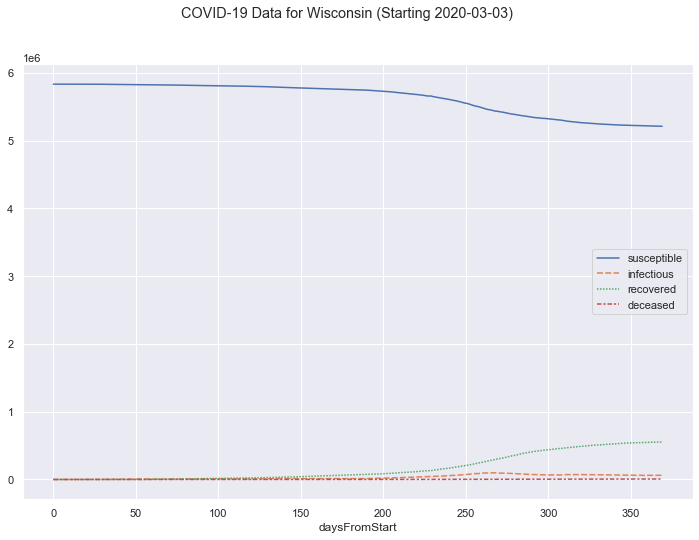

In [10]:
plt.suptitle(f"COVID-19 Data for {state} (Starting {data.iloc[0]['date'].date()})")
sb.lineplot(data=data)
plt.show()


The number of the susceptible is much greater than that of the others (otherwise that would be terrible). Since their sum is just the total population, we can choose not to be interested in the susceptible, and focus on the remaining cases instead.


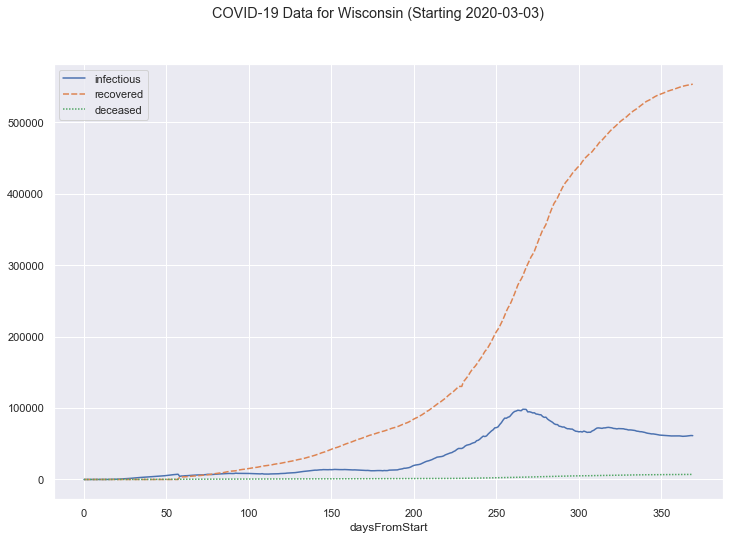

In [11]:
plt.suptitle(f"COVID-19 Data for {state} (Starting {data.iloc[0]['date'].date()})")
sb.lineplot(data=data[["infectious", "recovered", "deceased"]])
plt.show()


We do observe a pattern from the plot -- in the developing stage (in the middle of the horizontal axis), the cases seem to fit into some mathematical functions. We shall see how well they fit with our models later.


## Data Preparation

In order for us to model the data better, we first eliminate the very early portions of the data. We start by defining a utility function, `filter_data()`, which can extract data for a specific period of time.


In [12]:
def filter_data(data, start=None, end=None):
    filtered = data.reset_index().sort_values("date")
    if start: filtered = filtered[filtered["date"] >= start]
    if end: filtered = filtered[filtered["date"] < end]
    filtered.loc[:, "daysFromStart"] -= filtered.iloc[0]["daysFromStart"]
    filtered.set_index("daysFromStart", inplace=True)
    return filtered


With the help of the function, we can view the data from March and April 2020 (the early portion).


In [13]:
data_march_april = filter_data(data, start=data.iloc[0]['date'], end=datetime(2020, 5, 1))
data_march_april


,date,susceptible,infectious,recovered,deceased
daysFromStart,,,,,
0,2020-03-03,5832655,0,0,0
1,2020-03-04,5832654,1,0,0
2,2020-03-05,5832654,1,0,0
3,2020-03-06,5832654,1,0,0
4,2020-03-07,5832654,1,0,0
5,2020-03-08,5832654,1,0,0
6,2020-03-09,5832654,1,0,0
7,2020-03-10,5832653,2,0,0
8,2020-03-11,5832652,3,0,0


We observe a sudden increase in the number of recovered cases on 2020-04-30. (In fact, this sudden increase can be observed from the plot as well.) This is probably because the relevant data was not made available before that date. In order to obtain better models, we choose to leave out the data before that date.

In addition, from the plot, we can observe that there is a turning point at around the 265th day from the start (in late November or early December). This is thought to be attributed to the availability of the vaccine and strengthening control measures, and hence signals that the situation is starting to get better.

We are, however, more interested in the developing stage. Therefore, we may limit the period of interest within 150 days from 2020-04-30, the date when the number of recovered cases was made available.


In [14]:
date_start = datetime(2020, 4, 30)
date_end = date_start + timedelta(days=150)

print(f"date_start = {date_start.date()}")
print(f"  date_end = {date_end.date()}")


date_start = 2020-04-30
  date_end = 2020-09-27


We split the data into train and test data sets. We set the first half as train data, and the rest as test data. (The train data is only half of the whole data set, because under real circumstances we do not have time to gather much information -- in case of emergency, policy makers cannot wait!)


In [15]:
split_rate = 0.5
date_split = date_start + split_rate * (date_end - date_start)
train = filter_data(data, start=date_start, end=date_split)
test = filter_data(data, start=date_split, end=date_end)

print(f"date_split = {date_split.date()}")
train


date_split = 2020-07-14


,date,susceptible,infectious,recovered,deceased
daysFromStart,,,,,
0,2020-04-30,5824603,4384,3352,316
1,2020-05-01,5824105,4871,3352,327
2,2020-05-02,5823735,4888,3698,334
3,2020-05-03,5823428,5165,3723,339
4,2020-05-04,5823117,5225,3973,340
...,...,...,...,...,...
70,2020-07-09,5795445,9602,26792,816
71,2020-07-10,5794556,9949,27329,821
72,2020-07-11,5793575,10343,27909,828


## The SIRD Model


We first define a utility function, `get_SIRD_vars()`, to help us extract the data from the DataFrame. Here `t_train` is the time span, and `y_train` is the output (the four columns represent S, I, R and D, respectively).


In [16]:
def get_SIRD_vars(data):
    t = data.index.to_numpy(dtype=int)
    arr = data.to_numpy(dtype=int)
    _, S, I, R, D = arr.T  # leave the date out
    y = np.column_stack((S, I, R, D))
    return t, y


t_train, y_train = get_SIRD_vars(train)
print(f"t_train: {t_train.shape}")
print(f"y_train: {y_train.shape}")


t_train: (75,)
y_train: (75, 4)


We then define the SIRD model.

$\left\{
\begin{array}{rcl}
\dfrac{\strut dS}{\strut dt} & = & - \dfrac{\strut \beta I S}{\strut N}, \\
\dfrac{\strut dI}{\strut dt} & = & \dfrac{\strut \beta I S}{\strut N} - \gamma I - \mu I, \\
\dfrac{\strut dR}{\strut dt} & = & \gamma I, \\
\dfrac{\strut dD}{\strut dt} & = & \mu I.
\end{array}
\right.$

In `SIRD()`, we make use of the fact that $N = S + I + R + D$. (The assumption is that the population does not change over time.)


In [17]:
def SIRD(t, y, beta, gamma, mu):
    S, I, R, D = y
    N = np.sum((S, I, R, D))
    dS_dt = - beta * I * S / N
    dI_dt = beta * I * S / N - gamma * I - mu * I
    dR_dt = gamma * I
    dD_dt = mu * I
    return (dS_dt, dI_dt, dR_dt, dD_dt)


We then define our loss function (in this case, we use RMSE, the root-mean-square error). We use `iter_` to keep track of the number of iterations, and display some intermediate results. The function `solve_ivp` from `scipy.integrate` allows us to integrate the derivatives from `SIRD`, and hence get the values on the fitted line.


In [18]:
def loss_SIRD(k, t, y):
    """
    k: a tuple of parameters (beta, gamma, mu)
    t: time span
    y: expected output
    """
    global iter_
    S, I, R, D = y.T
    sol = solve_ivp(fun=SIRD, t_span=(t[0], t[-1]), y0=y[0], t_eval=t, dense_output=True, args=k)
    S_sol, I_sol, R_sol, D_sol = sol.y
    mse = np.mean(np.mean(((S_sol - S) ** 2, (I_sol - I) ** 2, (R_sol - R) ** 2, (D_sol - D) ** 2)))
    rmse = np.sqrt(mse)
    iter_ += 1
    print(f"Iteration #{'%4d' % iter_}: RMSE = {rmse}")
    clear_output(wait=True)
    return rmse


We then make use of `scipy.optimize.minimize()` to help us minimize the loss, and hence get the best-fitted line. [Truncated Newton (TNC) algorithm](https://en.wikipedia.org/wiki/Truncated_Newton_method) is used.


In [19]:
def fit_model(t, y):
    k0 = (0.1, 0.1, 0.01)  # initial guess values for (beta, gamma, mu)
    bounds = ((1e-4, 0.3), (1e-4, 0.3), (1e-4, 0.1))  # bounds for (beta, gamma, and mu)
    return minimize(fun=loss_SIRD, x0=k0, args=(t, y), method="Powell", bounds=bounds)
    # we can add options={"maxiter": <max iteration>} if we want


We can then proceed with the fitting.


In [20]:
iter_ = 0
SIRD_res = fit_model(t_train, y_train)
SIRD_res


   direc: array([[-3.30978314e-02, -3.32306314e-02, -1.20660392e-02],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [-3.30427178e-06,  2.27517030e-05, -1.89578150e-05]])
     fun: 873.4851973299296
 message: 'Optimization terminated successfully.'
    nfev: 291
     nit: 7
  status: 0
 success: True
       x: array([0.06336817, 0.04993697, 0.00160055])

We visualise the results with two plots. We should observe some similarity between the fitted values and the real ones.


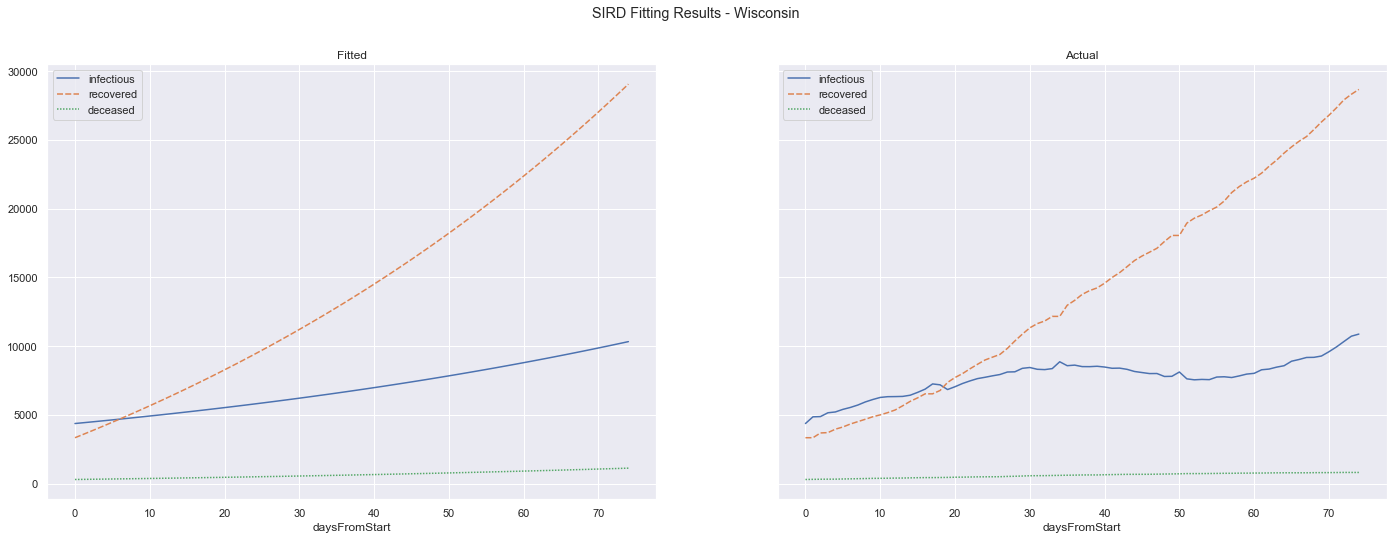

In [21]:
SIRD_res_y_array = np.array(solve_ivp(fun=SIRD, t_span=(t_train[0], t_train[-1]), y0=y_train[0], t_eval=t_train, dense_output=True, args=(SIRD_res.x)).y).T
SIRD_res_y = pd.DataFrame(SIRD_res_y_array, columns=["susceptible", "infectious", "recovered", "deceased"])
SIRD_res_y.index.rename("daysFromStart", inplace=True)

fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(24, 8))
plt.suptitle(f"SIRD Fitting Results - {state}")
axs[0].set_title("Fitted")
sb.lineplot(data=SIRD_res_y[["infectious", "recovered", "deceased"]], ax=axs[0])
axs[1].set_title("Actual")
sb.lineplot(data=train[["infectious", "recovered", "deceased"]], ax=axs[1])
plt.show()


As we see, despite some uncertainty in the infectious cases, the fitted result looks good. As we observe earlier from the numerical results, the RMSE is less than 1000. This is reasonably good, considering the large scale of our data.


## The ARIMA Model


The part with the ARIMA model is more straightforward -- we only utilise the infectious cases. But before we proceed, we need to find the best parameters for the ARIMA model. With the help from [this article](https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3), we may utilise `param_sel()` to help us with the selection.


In [22]:
infectious_train = train["infectious"]


In [23]:
def param_sel(data):
    import itertools
    import warnings
    warnings.filterwarnings("ignore")  # temporarily disables warnings
    p = d = q = range(2)
    # Generate all different combinations of p, d and q triplets
    pdq = list(itertools.product(p, d, q))
    aic = {}
    for param in pdq:
        try:
            mod = ARIMA(infectious_train, order=param)
            res = mod.fit()
            print(f"ARIMA{param} - AIC = {res.aic}")
            aic[res.aic] = param
        except:
            continue
    optimal = aic[min(aic)]
    print(f"The optimal parameters: {optimal}")
    warnings.filterwarnings("ignore", category=DeprecationWarning)  # restores warning filtering
    return optimal


param = param_sel(infectious_train)


ARIMA(0, 0, 0) - AIC = 1293.9845110802344
ARIMA(0, 0, 1) - AIC = 1209.630271456141
ARIMA(0, 1, 0) - AIC = 993.7180966254696
ARIMA(0, 1, 1) - AIC = 988.7043330583621
ARIMA(1, 0, 0) - AIC = 1016.5980351236775
ARIMA(1, 0, 1) - AIC = 1012.6279871399263
ARIMA(1, 1, 0) - AIC = 985.6104709318937
ARIMA(1, 1, 1) - AIC = 973.9429539313932
The optimal parameters: (1, 1, 1)


We can then use the optimal parameters to do the fitting -- straightforward.


In [24]:
model = ARIMA(infectious_train, order=param)
ARIMA_res = model.fit()


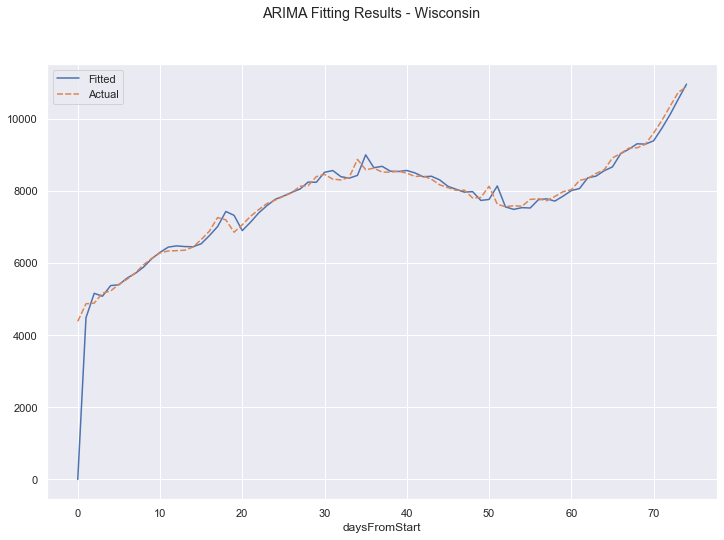

In [25]:
ARIMA_res_y = pd.DataFrame({"Fitted": ARIMA_res.fittedvalues, "Actual": infectious_train})

plt.suptitle(f"ARIMA Fitting Results - {state}")
sb.lineplot(data=ARIMA_res_y)
plt.show()


Since ARIMA does more complicated analysis on the data, there is no surprise that it fits the train data better -- we shall see later how well it predicts the test data.


## Using the Models to Predict Test Data


We first try with the SIRD model. The initial values are the last values of the train data (and hence we need to remove the initial values from the results -- they are not part of the prediction results). From this point onwards, we would be interested in the infectious numbers.


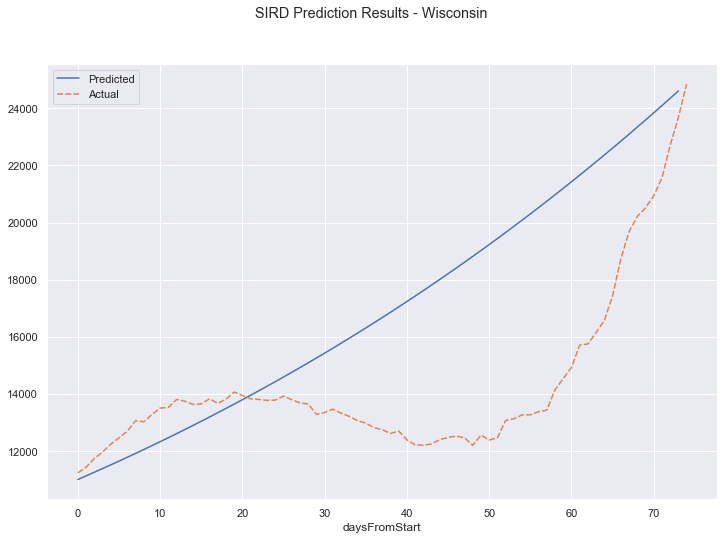

In [26]:
t_test, y_test = get_SIRD_vars(test)

SIRD_pred_array = np.array(solve_ivp(fun=SIRD, t_span=(t_test[0], t_test[-1]), y0=y_train[-1], t_eval=t_test, dense_output=True, args=(SIRD_res.x)).y).T
SIRD_pred_array = SIRD_pred_array[1:]  # remove the initial values
SIRD_pred_all = pd.DataFrame(SIRD_pred_array, columns=["susceptible", "infectious", "recovered", "deceased"])
SIRD_pred_all.index.rename("daysFromStart", inplace=True)
SIRD_pred = pd.DataFrame({"Predicted": SIRD_pred_all["infectious"], "Actual": test["infectious"]})

plt.suptitle(f"SIRD Prediction Results - {state}")
sb.lineplot(data=SIRD_pred)
plt.show()


As we can see, the results do not seem to be well fitted. We may have a look at the RMSE of the prediction.


In [27]:
def rmse(pred, actual):
    mse = np.mean((pred - actual) ** 2)
    rmse = np.sqrt(mse)
    return rmse


SIRD_rmse = rmse(SIRD_pred["Predicted"], SIRD_pred["Actual"])
SIRD_rmse


4055.398246042813

The model seems to fit better for the long run -- in the developing stage, despite the errors in the 40 - 60 days from start, the predictions go well in later dates. This seems to suggest the reasonableness of the model.


We may then see how the ARIMA model predicts.


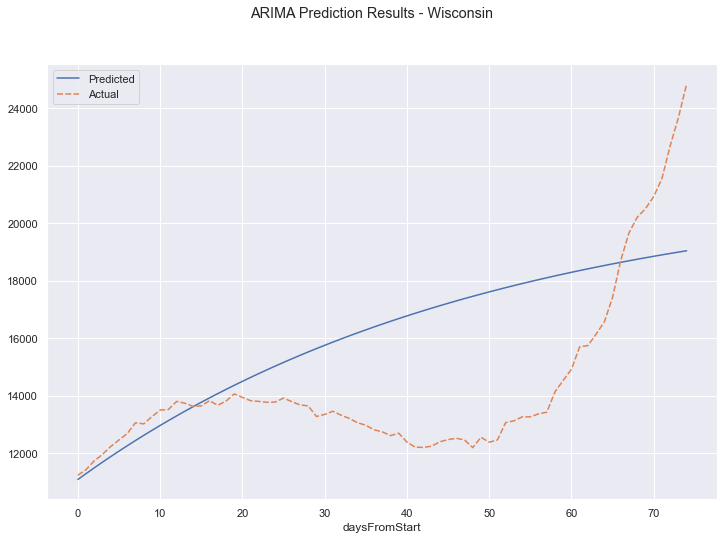

In [28]:
ARIMA_pred_array = np.array(ARIMA_res.forecast(len(test)))
ARIMA_pred = pd.DataFrame({"Predicted": ARIMA_pred_array, "Actual": test["infectious"]})
plt.suptitle(f"ARIMA Prediction Results - {state}")
sb.lineplot(data=ARIMA_pred)
plt.show()


In [29]:
ARIMA_rmse = rmse(ARIMA_pred["Predicted"], ARIMA_pred["Actual"])
ARIMA_rmse


3053.454220373098

As we can see, the prediction results from ARIMA tends to be an underestimate. They, however, have a smaller RMSE. As we can see, one of the reasons can be that the prediction goes well for the first 20 days. It seems that the ARIMA model, due to its nature, is good at providing short term predictions.


## Another Case Study


Before we draw a conclusion, it would be better to have a study on another state, so that we can validate our thoughts. This time, the state we choose is Kentucky, another inland state with conditions similar to that of Wisconsin.

The location of Kentucky in the United States:

![Kentucky in United States](https://upload.wikimedia.org/wikipedia/commons/e/e2/Kentucky_in_United_States.svg)

[Picture](https://commons.wikimedia.org/wiki/File:Kentucky_in_United_States.svg) from [TUBS](https://commons.wikimedia.org/wiki/User:TUBS), under CC BY-SA 3.0.


We follow the same procedure.


### Data Preparation


In [30]:
state2 = "Kentucky"

raw2 = get_data(state2)
population2 = get_population(state2)

data_cleanup(raw2)
data2 = extract_data(raw2, population2)

train2 = filter_data(data2, start=date_start, end=date_split)
test2 = filter_data(data2, start=date_split, end=date_end)


### The SIRD Model


In [31]:
t_train2, y_train2 = get_SIRD_vars(train2)

iter_ = 0
SIRD_res2 = fit_model(t_train2, y_train2)
SIRD_res2


   direc: array([[ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [-1.19514493e-02, -4.14927878e-03, -1.28858504e-02],
       [ 1.55275245e-05,  8.80765769e-05, -4.64028008e-05]])
     fun: 694.9933075962158
 message: 'Optimization terminated successfully.'
    nfev: 297
     nit: 7
  status: 0
 success: True
       x: array([0.03235067, 0.0079642 , 0.00122265])

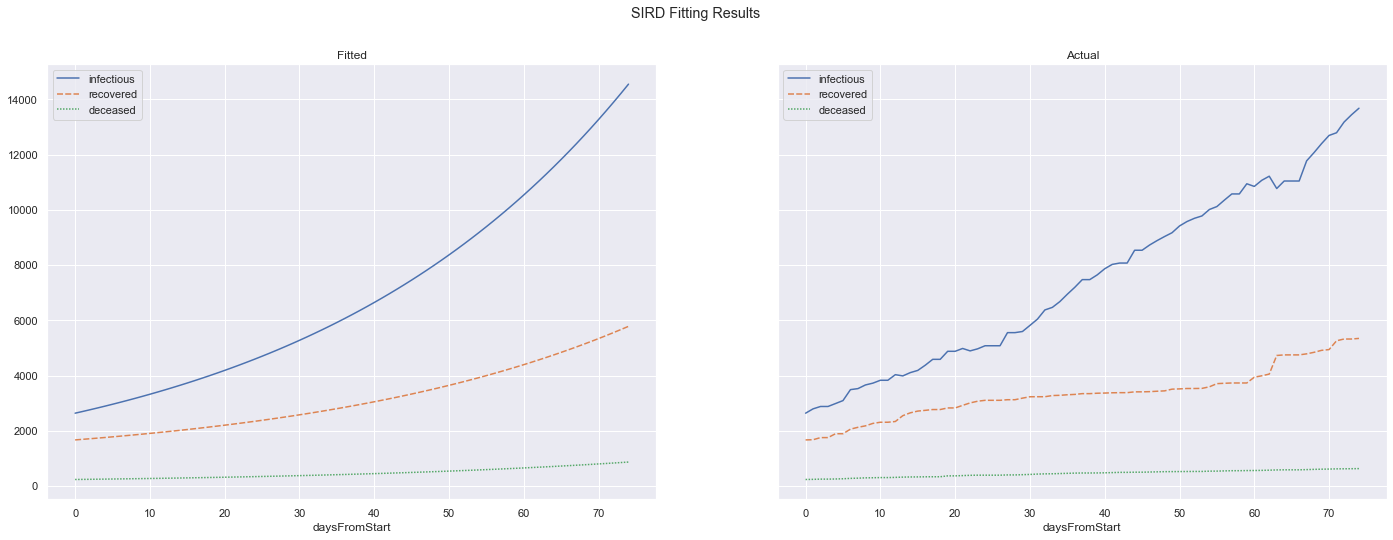

In [32]:
SIRD_res_y_array2 = np.array(solve_ivp(fun=SIRD, t_span=(t_train2[0], t_train2[-1]), y0=y_train2[0], t_eval=t_train2, dense_output=True, args=(SIRD_res2.x)).y).T
SIRD_res_y2 = pd.DataFrame(SIRD_res_y_array2, columns=["susceptible", "infectious", "recovered", "deceased"])
SIRD_res_y2.index.rename("daysFromStart", inplace=True)

fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(24, 8))
plt.suptitle("SIRD Fitting Results")
axs[0].set_title("Fitted")
sb.lineplot(data=SIRD_res_y2[["infectious", "recovered", "deceased"]], ax=axs[0])
axs[1].set_title("Actual")
sb.lineplot(data=train2[["infectious", "recovered", "deceased"]], ax=axs[1])
plt.show()


### The ARIMA Model


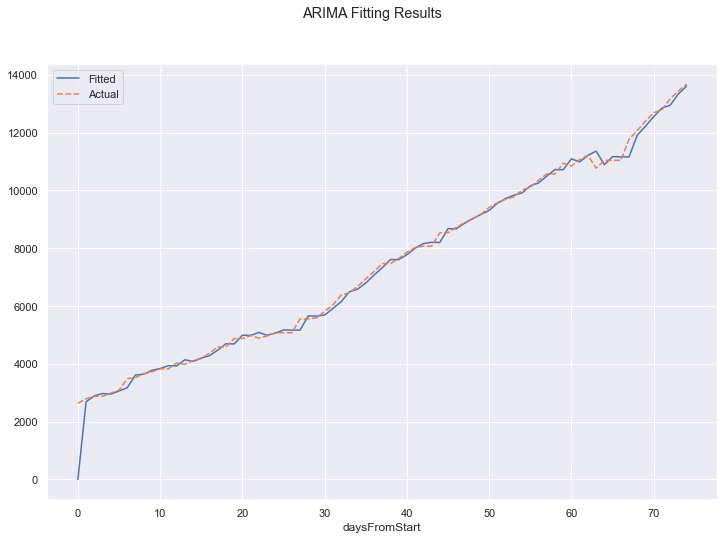

In [33]:
infectious_train2 = train2["infectious"]

model2 = ARIMA(infectious_train2, order=param)
ARIMA_res2 = model2.fit()

ARIMA_res_y2 = pd.DataFrame({"Fitted": ARIMA_res2.fittedvalues, "Actual": infectious_train2})

plt.suptitle("ARIMA Fitting Results")
sb.lineplot(data=ARIMA_res_y2)
plt.show()


### Predicting Test Data

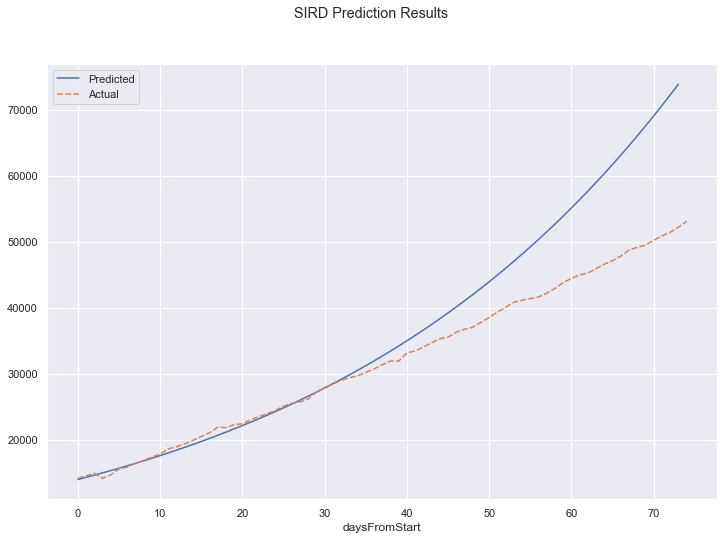

In [34]:
t_test2, y_test2 = get_SIRD_vars(test2)

SIRD_pred_array2 = np.array(solve_ivp(fun=SIRD, t_span=(t_test2[0], t_test2[-1]), y0=y_train2[-1], t_eval=t_test2, dense_output=True, args=(SIRD_res2.x)).y).T[1:]
SIRD_pred_all2 = pd.DataFrame(SIRD_pred_array2, columns=["susceptible", "infectious", "recovered", "deceased"])
SIRD_pred_all2.index.rename("daysFromStart", inplace=True)
SIRD_pred2 = pd.DataFrame({"Predicted": SIRD_pred_all2["infectious"], "Actual": test2["infectious"]})

plt.suptitle("SIRD Prediction Results")
sb.lineplot(data=SIRD_pred2)
plt.show()


In [35]:
def rmse(pred, actual):
    mse = np.mean((pred - actual) ** 2)
    rmse = np.sqrt(mse)
    return rmse


SIRD_rmse2 = rmse(SIRD_pred2["Predicted"], SIRD_pred2["Actual"])
SIRD_rmse2


7772.237655226531

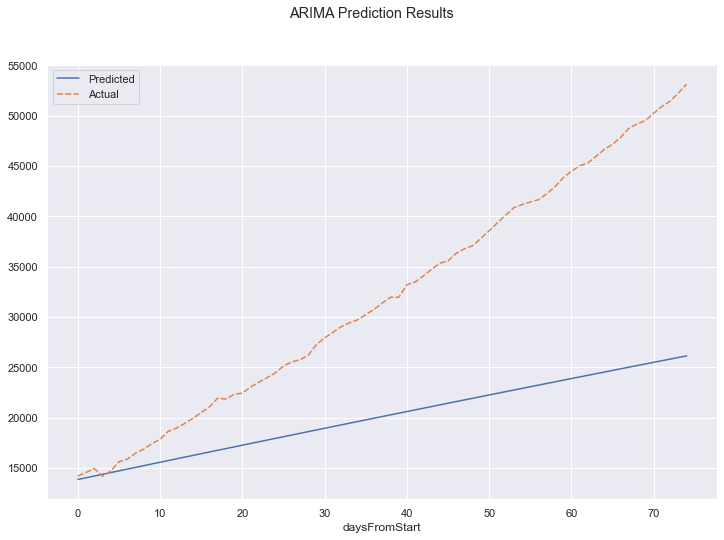

In [36]:
ARIMA_pred_array2 = np.array(ARIMA_res2.forecast(len(test2)))
ARIMA_pred2 = pd.DataFrame({"Predicted": ARIMA_pred_array2, "Actual": test2["infectious"]})
plt.suptitle("ARIMA Prediction Results")
sb.lineplot(data=ARIMA_pred2)
plt.show()


In [37]:
ARIMA_rmse2 = rmse(ARIMA_pred2["Predicted"], ARIMA_pred2["Actual"])
ARIMA_rmse2


14331.898871587973

In the Kentucky case, we observe that the SIRD model predicts more accurately. The ARIMA model, unlike the SIRD model, does not make use of the characteristics of the disease, and treats the data as normal information only. That is the limitation of the ARIMA model.


## Conclusion

__TODO__
